In [1]:
import os
from glob import glob
from pandas import DataFrame
import pandas as pd
import configparser
import subprocess as sp
import matplotlib.pyplot as plt
import pprint

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
bench_start = '2018-11-08_00:12:48'
bench_end = '2018-11-08_02:54:12'

experiments_path = '/home/dongwonshin/Desktop/SLAM_eval/Experiment_Results'
all_benchmarks = sorted(glob('%s/*' % experiments_path))

# benchmark filtereing
filtered_benchmarks = []
for benchmark in all_benchmarks:
    if (bench_start <= benchmark.split('/')[-1] and benchmark.split('/')[-1] <= bench_end):
        filtered_benchmarks.append(benchmark)

segmap_config_table = DataFrame()
for benchmark in filtered_benchmarks:
    config = configparser.ConfigParser()
    config.read(os.path.join(benchmark, 'POI.ini'))
    target_kitti_data = config.get('PARAMETERS','target_kitti_data')
    icp_config = config.get('PARAMETERS','icp_config')
    odom_config = config.get('PARAMETERS','odom_config')

    segmap_config_table = segmap_config_table.append({"benchmark_path": benchmark.split('/')[-1],
                                                      "target_kitti_data": target_kitti_data, 
                                                      "icp_config": icp_config, 
                                                      "odom_config" : odom_config}, ignore_index = True)

In [3]:
segmap_config_table

,benchmark_path,icp_config,odom_config,target_kitti_data
0,2018-11-08_00:12:48,semantic_icp,with_odom,0
1,2018-11-08_00:20:49,semantic_icp,without_odom,0
2,2018-11-08_00:28:48,ordinary_icp,with_odom,0
3,2018-11-08_00:36:47,ordinary_icp,without_odom,0
4,2018-11-08_00:38:57,semantic_icp,with_odom,1
5,2018-11-08_00:41:05,semantic_icp,without_odom,1
6,2018-11-08_00:43:13,ordinary_icp,with_odom,1
7,2018-11-08_00:45:21,ordinary_icp,without_odom,1
8,2018-11-08_00:53:31,semantic_icp,with_odom,2
9,2018-11-08_01:01:45,semantic_icp,without_odom,2


In [4]:
from evo.tools import log
log.configure_logging(verbose=False, debug=False, silent=True)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

from evo.tools import file_interface
from evo.core import sync
from evo.core import trajectory
from evo.core import metrics

import itertools

In [6]:
def absolute_trajectory_error(ref_file, est_file, eval_type):
    traj_ref = file_interface.read_tum_trajectory_file(ref_file)
    traj_est = file_interface.read_tum_trajectory_file(est_file)

    max_diff = 0.01

    traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)
    traj_est_aligned = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=True)

    if (eval_type=='translation'):
        pose_relation = metrics.PoseRelation.translation_part
    elif (eval_type=='rotation'):
        pose_relation = metrics.PoseRelation.rotation_part

    data = (traj_ref, traj_est_aligned) 

    ape_metric = metrics.APE(pose_relation)
    ape_metric.process_data(data)

    ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
    
    return ape_stat/traj_ref.get_infos()['path length (m)']

In [7]:
def result_for_conditions(odom_config, icp_config, verbose):
    
    if (verbose):
        print(odom_type, ',', icp_config)

    target_table = segmap_config_table[
                        (segmap_config_table['odom_config']==odom_config)
                      & (segmap_config_table['icp_config']==icp_config)
                    ]

    t_result_list = []
    r_result_list = []
    for index, row in target_table.iterrows():

        if (verbose):
            print('target kitti data : ', row['target_kitti_data'])
        benchmark_path = row['benchmark_path']
        target_kitti_data =  row['target_kitti_data']

        ref_file = "/home/dongwonshin/Downloads/dataset/poses/%02d_time.txt" % int(target_kitti_data)
        est_file = "/home/dongwonshin/Desktop/SLAM_eval/Experiment_Results/%s/trajectory.csv" % benchmark_path

        translation_error = absolute_trajectory_error(ref_file, est_file, 'translation')
        rotation_error = absolute_trajectory_error(ref_file, est_file, 'rotation')

        if (verbose):
            print('translation error \t', translation_error)
            print('rotation error \t\t', rotation_error)

        t_result_list.append(translation_error)
        r_result_list.append(rotation_error)
        
    return t_result_list, r_result_list

In [8]:
odom_configs = ['with_odom', 'without_odom']
icp_configs = ['ordinary_icp', 'semantic_icp']

translation_error_list = {}
rotation_error_list = {}
for odom_config, icp_config in itertools.product(odom_configs, icp_configs):
    t_result_list, r_result_list = result_for_conditions(odom_config, icp_config,verbose=False)
    translation_error_list[odom_config + '_' + icp_config] = t_result_list
    rotation_error_list[odom_config + '_' + icp_config] = r_result_list

In [11]:
%matplotlib inline

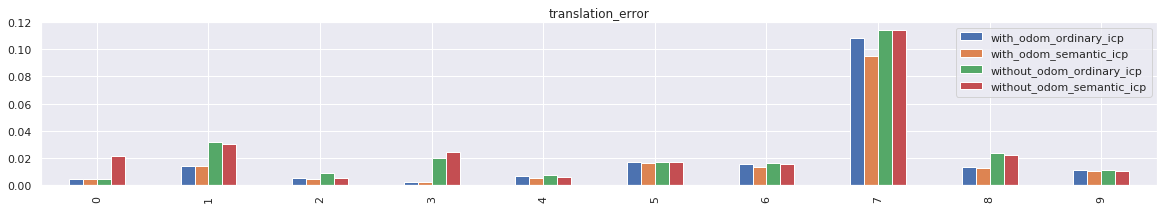

In [12]:
translation_error_df = pd.DataFrame.from_dict(translation_error_list)
plt.rcParams["figure.figsize"] = (20,3)
translation_error_df.plot(kind = 'bar')
plt.title('translation_error')
plt.show()

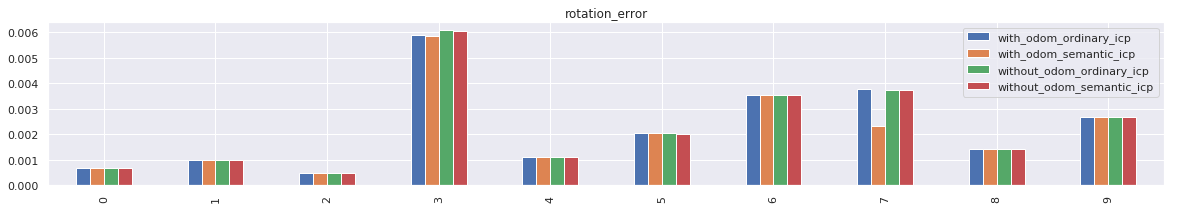

In [13]:
rotation_error_df = pd.DataFrame.from_dict(rotation_error_list)
plt.rcParams["figure.figsize"] = (20,3)
rotation_error_df.plot(kind = 'bar')
plt.title('rotation_error')
plt.show()

In [14]:
translation_error_df

,with_odom_ordinary_icp,with_odom_semantic_icp,without_odom_ordinary_icp,without_odom_semantic_icp
0,0.004674,0.004672,0.004807,0.021132
1,0.013961,0.014360,0.031987,0.030062
2,0.005471,0.004692,0.009187,0.005153
3,0.002328,0.002530,0.019768,0.024203
4,0.006689,0.005670,0.007695,0.006018
5,0.017266,0.016325,0.017126,0.017326
6,0.015494,0.013779,0.016015,0.015921
7,0.108271,0.094739,0.113954,0.113911
8,0.013386,0.012646,0.023494,0.022204
9,0.011225,0.010482,0.011225,0.010179


In [15]:
rotation_error_df

,with_odom_ordinary_icp,with_odom_semantic_icp,without_odom_ordinary_icp,without_odom_semantic_icp
0,0.000663,0.000663,0.000663,0.000658
1,0.000993,0.000994,0.000987,0.000988
2,0.000485,0.000484,0.000483,0.000483
3,0.005880,0.005856,0.006082,0.006058
4,0.001118,0.001117,0.001119,0.001120
5,0.002040,0.002029,0.002036,0.002022
6,0.003540,0.003535,0.003534,0.003535
7,0.003768,0.002320,0.003742,0.003742
8,0.001437,0.001437,0.001432,0.001433
9,0.002660,0.002659,0.002660,0.002663


In [19]:
translation_error_df.mean()

with_odom_ordinary_icp       0.019876
with_odom_semantic_icp       0.017990
without_odom_ordinary_icp    0.025526
without_odom_semantic_icp    0.026611
dtype: float64

In [17]:
rotation_error_df.mean()

with_odom_ordinary_icp       0.002258
with_odom_semantic_icp       0.002109
without_odom_ordinary_icp    0.002274
without_odom_semantic_icp    0.002270
dtype: float64